# Yeast cells detection evaluation notebook

Evaluates the performance of segmentation and tracking on the YIT ground truth data set. 

Performances are displayed as calibration curves over the `segmentation_threshold`, and as a calibration heatmap over the tracking hyperparameters `dmax` and `epsilon`.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import files 
import matplotlib.pyplot as plt
from skimage.io import imread
from tqdm.auto import tqdm
from scipy.sparse import coo_matrix
from itertools import product
import warnings
from sklearn.exceptions import EfficiencyWarning
%matplotlib notebook

# Install detectron2 based on the installed version of torch,
# we assume torchvision is already installed as is the case on Google Colab.
try:
    import torch
    import detectron2
except ImportError:
    torch_version, cuda_version = torch.__version__.split('+cu')
    torch_version = '.'.join(torch_version.split('.')[:2])
    !pip3 install -U pyyaml
    !pip3 install detectron2 -f "https://dl.fbaipublicfiles.com/detectron2/wheels/cu{cuda_version}/torch{torch_version}/index.html"
    import detectron2

try:
  from download import download
except ImportError:
  !pip3 install download
  from download import download

try:
    from yeastcells import data, model, clustering, features, visualize, evaluation
    # raise ImportError() # force a new checkout from the repository
except ImportError:
    !test -e yeastcells-detection-maskrcnn || git clone https://github.com/ymzayek/yeastcells-detection-maskrcnn.git
    !cd yeastcells-detection-maskrcnn; git pull origin main
    !pip3 install ./yeastcells-detection-maskrcnn
    from yeastcells import data, model, clustering, features, visualize, evaluation

In [2]:
# Tested thresholds
thresholds = np.arange(.8, 1, 0.005)

# Tested hyperparameter values for tracking
dmaxs = np.arange(2, 7, 1)
epsilons = np.arange(0.35, 0.91, 0.05)

# Selected threshold
segmentation_threshold=0.955

## Download model and data

In [3]:
pipeline_path = f'/content/yeastcells-detection-maskrcnn'

download(
    'https://datascience.web.rug.nl/models/yeast-cells/mask-rcnn/v1/model_final.pth',
    f'{pipeline_path}/model_final.pth'
)

download(
    'https://datascience.web.rug.nl/YIT-Benchmark2.zip', 
    f'{pipeline_path}/YIT-Benchmark2/YIT-Benchmark2.zip'
)

# Extract the YIT-Benchmark2.zip if the folder doesn't exist or the content is
# smaller than 500MB (heuristic).
extracted_size = !du -s '{pipeline_path}/YIT-Benchmark2/'
if not os.path.exists(f'{pipeline_path}/YIT-Benchmark2/') or \
   int(''.join(extracted_size).split()[0]) < 500*1024: 
  !cd '{pipeline_path}' && unzip -o 'YIT-Benchmark2/YIT-Benchmark2.zip' -d YIT-Benchmark2
else:
  print('It seems the YIT-Benchmark2 data set is extracted alread extracted')

testset = 'TestSet1'
filenames = data.load_data(f'{pipeline_path}/YIT-Benchmark2/{testset}/RawData', ff = '.tif')

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.
It seems the YIT-Benchmark2 data set is extracted alread extracted


In [4]:
assert len(filenames) > 0, "No images were found"

image = [imread(filename) for filename in filenames]

assert len({im.shape for im in image}) == 1, (
    f"Images have inconsistent shapes: "
    f"{', '.join({'x'.join(map(str, im.shape)) for im in image})}")

image = np.concatenate([frame[None, ..., None] * [[[1.,1.,1.]]] for frame in image])
image = (255 * image / image.max()).astype(np.uint8)
image.shape #(frames, length, width, channels)

(60, 512, 512, 3)

## Ground truth

The ground truth consists of annotations of
 * `frame`: frame number starting at 1,
 * `cell`: tracks cells over frames, and
 * `x`, `y`: cell position.

In [5]:
ground_truth = pd.read_csv(
    f'{pipeline_path}/YIT-Benchmark2/{testset}/GroundTruth/GroundTruth_Segmentation.csv',
    sep=', ' # there's an awkward space next to the commas
).drop('Cell_colour', axis=1).rename(
    {'Frame_number': 'frame',	'Cell_number': 'cell',
     'Position_X' :'x', 'Position_Y': 'y'}, axis=1).reindex()

# detections start counting at 0, ground truths at 1. rectify:
ground_truth['frame'] = ground_truth['frame'] - 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


## Segmentation theshold optimization

### Preparation

Calculate intermediate results, that are independent of the thresholds and can be filtered by the threshold.

This includes the all detections, the IoU distances between pairwise detections close enough in time and the centroid coordinates of each detection.

In [6]:
predictor = model.load_model(
    f'{pipeline_path}/model_final.pth', seg_thresh=float(thresholds.min()), device='cuda:0') 

# Detection output from the Mask-RCNN
output = [{'instances': predictor(frame)['instances'].to('cpu')} for frame in tqdm(image)]

# IoU distances between detections, stored sparsely
distances = clustering.get_distances(output, dmax=5, progress=True)

### Evaluation

Filters out intermediate results based on different threshold values, and reapplies tracking (DBScan clustering).

In [7]:
metrics = []

for i, threshold in enumerate(tqdm(thresholds)):
  # remove insufficiently certain detections based on threshold
  output_ = [
      {'instances': frame['instances'][frame['instances'].scores > threshold]}
      for frame in output
  ]

  # remove insufficiently certain detections from distance matrix based on threshold
  above_threshold = np.concatenate([
    frame['instances'].scores > threshold for frame in output])
  distances_ = distances.tocsr()[above_threshold].tocsc()[:, above_threshold].tocoo()

  # Cluster detections (e.g. tracking)
  with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=EfficiencyWarning)
    labels = clustering.DBSCAN(
        eps=0.6, min_samples=3, metric='precomputed'
    ).fit(distances_).labels_

  masks = np.concatenate([frame['instances'].pred_masks for frame in output_])
  detections = pd.DataFrame({
      'frame': [frame for frame, o in enumerate(output_)
                      for _ in range(len(o['instances']))],
      'cell': labels, 'mask': np.arange(len(masks)),
  }).reindex()

  segmentation_metrics = evaluation.calculate_metrics(
      evaluation.get_segmention_metrics(ground_truth, detections, masks))
  tracking_metrics = evaluation.calculate_metrics(
      evaluation.get_tracking_metrics(ground_truth, detections, masks))

  metrics.extend([
      {'task': task, 'metric': metric, 'value': value, 'threshold': threshold}
      for task, result in {
          'tracking': tracking_metrics,
          'segmentation': segmentation_metrics}.items()
      for metric, value in result.items()
  ])
results = pd.DataFrame(metrics)

### Results

The performance of segmentation and tracking shown as calibration curves with respect to the threshold

#### Calibration curves

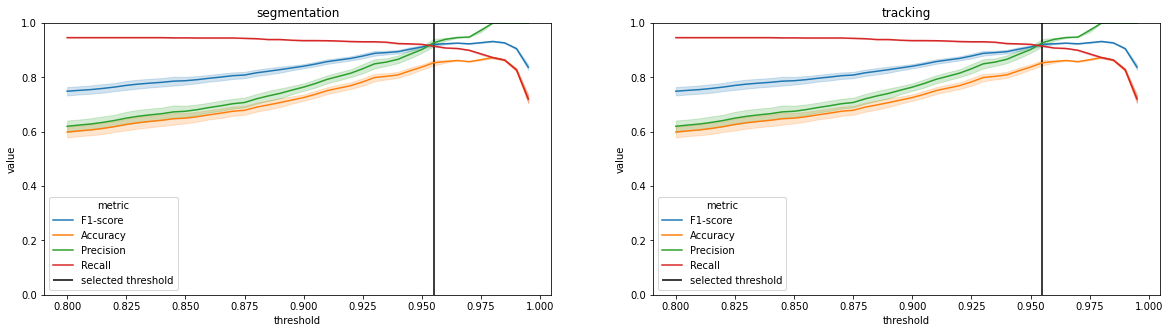

In [8]:
axes = plt.subplots(1, 2, figsize=(20, 5))[1].ravel()
for (task, task_results), axis in zip(results.groupby('task'), axes):
  axis.vlines(segmentation_threshold, 0, 1, label='selected threshold')
  sns.lineplot(data=results, x='threshold', y='value', hue='metric', ax=axis)
  axis.set_title(task); axis.set_ylim(0, 1)

#### Performance at selected threshold

In [9]:
results[(results['threshold'] - 0.955)**2 < 1e-6].pivot('task', columns='metric', values='value')

metric,Accuracy,F1-score,Precision,Recall
task,,,,
segmentation,0.843725,0.915240,0.913675,0.916810
tracking,0.863787,0.926916,0.941176,0.913082


### Export

Export as spreadsheet.

In [10]:
results.pivot(index=['threshold'], columns=['task', 'metric'], values='value').to_excel('threshold-tuning-results.xlsx')

try:
  from google.colab.files import download
  download('threshold-tuning-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Tuning `dmax` and `epsilon` hyperparameters for tracking

### Preparation

IoU distances used for clustering are stored for the most generous (higest) maximum frame (time) different considered. For testing, distances for detections too far appart are removed, such that DBScan assumes they are infinite.

In [11]:
predictor = model.load_model(
    f'{pipeline_path}/model_final.pth', seg_thresh=segmentation_threshold, device='cuda:0') 

# Detection output from the Mask-RCNN
output = [{'instances': predictor(frame)['instances'].to('cpu')} for frame in tqdm(image)]

# IoU distances between detections, stored sparsely
distances = clustering.get_distances(output, dmax=dmaxs.max(), progress=True)

# Segmentation masks to be aligned with the `detections` dataframe below.
masks = np.concatenate([frame['instances'].pred_masks for frame in output])

# detection ground truths, the `cell` column will be updated each
# iteration in the cell below, as it represents the result of tracking,
# of which the hyperparameters are tuned.
detections = pd.DataFrame({
    'frame': [frame for frame, o in enumerate(output)
                    for _ in range(len(o['instances']))],
    'cell': -1, 'mask': np.arange(len(masks)),
}).reindex()
frames = detections['frame'].values

### Evaluation

In [12]:
metrics = []

for dmax, epsilon in tqdm(list(product(dmaxs, epsilons))):
    # Remove distances that where from detections too many frames appart
    at_most_dmax = np.abs(frames[distances.col] - frames[distances.row]) < dmax
    distances_ = coo_matrix(
        (distances.data[at_most_dmax],
         (distances.row[at_most_dmax], distances.col[at_most_dmax])),
        shape=distances.shape
    )
    # sanity check, should always hold
    assert (distances.nnz - distances_.nnz - (distances - distances_).nnz) == 0, (
        "Insane, distances_ differs from distances on non-zero items")

    # Cluster detections (e.g. tracking)
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=EfficiencyWarning)
      labels = clustering.DBSCAN(
          eps=epsilon, min_samples=3, metric='precomputed'
      ).fit(distances_).labels_
    detections['cell'] = labels


    tracking_metrics = evaluation.calculate_metrics(
      evaluation.get_tracking_metrics(ground_truth, detections, masks))

    metrics.extend([
        {'metric': metric, 'value': value, 'epsilon': epsilon, 'dmax': dmax}
        for metric, value in tracking_metrics.items()
    ])
tracking_results = pd.DataFrame(metrics)

### Results

Several performance metric represented by bars or a heatmap for different `eps` and `dmax` values.

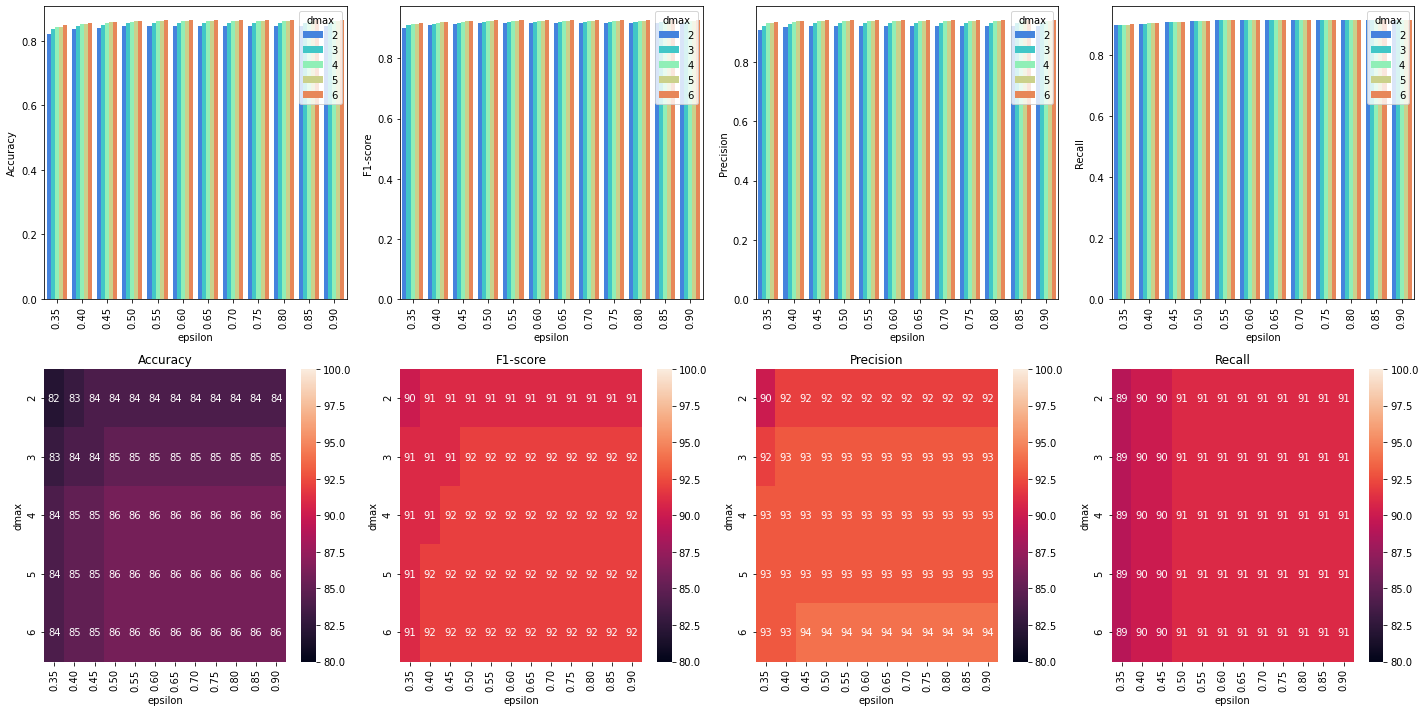

In [13]:
axes = plt.subplots(2, 4, figsize=(20, 10))[1].T

for (metric, rows), (ax0, ax1) in zip(tracking_results.groupby('metric'), axes):
  rows = rows.rename({'value': metric}, axis=1)
  sns.barplot(data=rows.rename({'value': metric}, axis=1),
              hue='dmax', x='epsilon', y=metric, palette='rainbow', ax=ax0)
  ax0.set_xticklabels([f'{eps:0.2f}' for eps in epsilons], rotation=90)
  ax1.set_ylim(0, 1)

  # Show as pecentages
  rows = (100 * rows.pivot('dmax', columns=['epsilon'], values=metric)).astype(int)
  sns.heatmap(data=rows, annot=True, ax=ax1, vmin=80, vmax=100, fmt='d')
  ax1.set_xticklabels([f'{eps:0.2f}' for eps in epsilons], rotation=90)
  ax1.set_title(metric)
plt.tight_layout()

### Export

Save and download these results as a spreadsheets.

In [14]:
tracking_results.pivot(index=['dmax', 'epsilon'], columns=['metric'], values='value').to_excel('tracking-tuning-results.xlsx')

try:
  from google.colab.files import download
  download('tracking-tuning-results.xlsx')
except ImportError:
  print('Not on Google Colab, won\'t start download')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>